In [133]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
from uszipcode import ZipcodeSearchEngine
from shapely.geometry import Point
import geojson
import json
import pickle
import folium
from folium import plugins
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(style="whitegrid")

In [111]:
# read in cleaned rentals data as geodataframe
data = pd.read_csv("cleaned_data_final.csv")
# convert latitude and longitude points into GIS data points
geometry = [Point(xy) for xy in zip(data['geocode_lon'], data['geocode_lat'])]
# set projections for geometry 
crs = {'init': 'epsg:4326'}
locations = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
locations = locations.to_crs({'init': 'epsg:4326'})

In [112]:
# create geodataframe of zipcodes of Minnesota
zipcodes = gpd.GeoDataFrame.from_file('zip_code_tabulation_areas.shp')
# set projection of zipcodes
zipcodes = zipcodes.to_crs({'init': 'epsg:4326'})
# rename column of minnesota zipcodes file
zipcodes = zipcodes.rename(columns={'GEOID10': 'zipcodes'})
# perform spatial join between craigslist 
loc_zip_join = gpd.sjoin(locations, zipcodes, how="left", op='within')
# re-size dataframe to only include necessary columns
final_df = loc_zip_join[['address', 'beds boolean', 'beds_baths', 'county', 'county_full', 'datetime', 'geocode_lat', 'geocode_lon', 'post id', 'price', 'price boolean', 'square feet', 'square feet boolean', 'title', 'url', 'County', 'City', 'bed assigned', 'no match', 'index match', 'outlier', 'zipcodes']]

In [113]:
# create dictionary of the fair market rents of the Twin Cities according to 
fmr_dict = {"studio" : 711, "1" : 864, "2" : 1089, "3" : 1547, "4" : 1812}
# function to determine how many standard deviations over or under fmr rent is 
def over_under_fmr(df, col_name, std_dictionary, fmr_dictionary, std_list):
    # define crunch_fmr to calculate if price is over threshold for given standard deviation
    def crunch_fmr(beds, **kwargs):
    # get standard deviation for given beds value, add it to fmr value, multiply it by number of standard deviations
        return float(fmr_dictionary.get(beds)) - (float(std_dictionary.get(beds)) * float(standard_deviation))
    # loop through list of std 1-3
    for standard_deviation in std_list:
        # new column for each standard deviation threshold
        std_column_name = "over fmr" + str(standard_deviation)
        df[std_column_name] = 0
        # apply crunch_fmr
        df.loc[(df[col_name] < df['beds_baths'].apply(crunch_fmr, fmr_dictionary=fmr_dictionary, std_dictionary = std_dictionary, threshold = standard_deviation)), std_column_name] = 1
    return df  

In [132]:
# pickle filenames
filenames = ['sqft_std_dict.pickle', 'sqft_mean_dict.pickle', 'price_mean_dict.pickle', 'price_std_dict.pickle']
# function to import pickle files as dictionaries with standard deviations and means for prices and square feet data
def pickle_to_dict(filenames):
    dictionaries_list = []
    for file in filenames:
        with open(file, 'rb') as handle:
            unserialized_data = pickle.load(handle)
            dictionaries_list.append(unserialized_data)
    return dictionaries_list
# run function to save dictionaries for use in a later script
sqft_std_dict, sqft_mean_dict, price_mean_dict, price_std_dict = pickle_to_dict(filenames)


In [115]:
# list of values 1, 2, 3 for standard deviations
std_list = [1, 2, 3]
# run over_fmr function to create dataframe with booleans of rentals 1, 2, 3 standard deviations over fmr
df_vals_over_fmr = over_under_fmr(final_df, 'price', price_std_dict, fmr_dict, std_list)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [116]:
# copy dataframe as df_vals_over_fmr will be modified
final_zipcodes = df_vals_over_fmr
#convert studio to one in order to sum number of craigslist units per zip code
df_vals_over_fmr.loc[df_vals_over_fmr['beds_baths'] == "studio", "beds_baths"] = "1"
# convert beds_baths to float
df_vals_over_fmr['beds_baths'] = df_vals_over_fmr['beds_baths'].astype(float)
# sum number of beds baths in zipcodes
beds_per_zip_craigslist = df_vals_over_fmr.groupby('zipcodes')['beds_baths'].sum()
# reset index of dataframe and rename columns
beds_per_zip_craigslist = beds_per_zip_craigslist.reset_index()
beds_per_zip_craigslist = beds_per_zip_craigslist.rename(columns={'beds_baths': 'craigslist beds per zip'})


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [117]:
# function to perform operations on dataframes 
# for 1,2,3 standard deviations over fmr
def munge_over_fmr(dfs):
    dataframes = []
    for dataframe in dfs:
        # sum the number of units over fmr
        over_fmr_sum = dataframe.groupby('zipcodes')['beds_baths'].sum()
        # reindex dataframe
        over_fmr_craigslist = over_fmr_sum.reset_index()
        over_fmr_craigslist = over_fmr_craigslist.rename(columns={'beds_baths': 'craigslist beds per zip over fmr'})
        # merge dataframe sums of craigslist per zipcode and sums of overfmr listings per zipcode
        merged = pd.concat(objs = [beds_per_zip_craigslist.set_index('zipcodes'), over_fmr_craigslist.set_index('zipcodes')], axis = 1)
        # create zipcodes column
        merged['zipcodes'] = merged.index
        # create columns of new information from US Census from ZipcodeSearchEngine
        for index, row in merged.iterrows():
            # call zipcode search engine
            search = ZipcodeSearchEngine()
            # input each zipcode from dataframe into search engine
            zipcode=search.by_zipcode(row['zipcodes'])
            # get total number of units per zipcode according to census
            units_tot = zipcode.HouseOfUnits
            # get wealth rating of zipcode
            wealth = zipcode.Wealthy
            # create columns of total units and wealth in dataframe
            merged.loc[index, 'total units'] = units_tot
            merged.loc[index, 'wealth'] = wealth
        # reindex dataframe
        index_list = list(range(len(merged.index)))
        # make index series a column in dataframe
        merged['index'] = index_list
        # set index column as index of dataframe
        merged = merged.set_index(['index'])
        # fill na
        merged = merged.fillna(0)
        # coerce columns
        merged['total units'] = pd.to_numeric(merged['total units'], errors = "coerce")
        merged['craigslist beds per zip'] = pd.to_numeric(merged['craigslist beds per zip'], errors = "coerce")
        merged['craigslist beds per zip over fmr'] = pd.to_numeric(merged['craigslist beds per zip over fmr'], errors = "coerce")
        merged['wealth'] = pd.to_numeric(merged['wealth'].astype(float), errors = "coerce")
        # calculate percent of craigslist listings per total units in zipcode
        merged['craigslist pct per total units'] = 0
        # cast column as float
        merged['craigslist pct per total units'] = merged['craigslist pct per total units'].astype(float)
        # calculate column craigslist pct per total units which tries to estimate how many units per zipcode
        # are available on craigslist
        merged['craigslist pct per total units'] = merged['craigslist beds per zip'].div(merged['total units'])
        # percent of craigslist listings x standard deviations over fmr 
        merged['craigslist pct over fmr'] = 0 
        # cast as float
        merged['craigslist pct over fmr'] = merged['craigslist pct over fmr'].astype(float)
        # percent of craigslist listings per craigslist total in zip code
        merged['craigslist pct over fmr'] = merged['craigslist beds per zip over fmr'].div(merged['craigslist beds per zip'])
        # attempt to calculate measure of wealth and unaffordability
        merged['normalized measure of over fmr'] = merged['craigslist pct over fmr'] * merged['craigslist pct per total units']
        # calculate percent of craigslist data per zipcode
        merged['pct of listings by craigslist population'] = merged['craigslist beds per zip'].div(19240)
        # calculate the mean weatlh number
        wealth_avg = np.mean(merged['wealth'])
        # create boolean of above and below average wealth 
        merged['above avg'] = False
        merged.loc[merged['wealth'] > wealth_avg, 'above avg'] = True
        dataframes.append(merged)
    return dataframes

In [118]:
# sum of over fmr units per zipcode house of units
over_fmr_1 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr1'] == 1]
over_fmr_2 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr2'] == 1]
over_fmr_3 = df_vals_over_fmr.loc[df_vals_over_fmr['over fmr3'] == 1]
# create list of dataframes with over fmr rows
dfs = [over_fmr_1, over_fmr_2, over_fmr_3]
# munge dataframes 
munged1, munged2, munged3 = munge_over_fmr(dfs)

In [120]:
zipcodes = gpd.GeoDataFrame.from_file('zip_code_tabulation_areas.shp')
# set projection of zipcodes
zipcodes = zipcodes.to_crs({'init': 'epsg:4326'})
# rename column of minnesota zipcodes file
zipcodes = zipcodes.rename(columns={'GEOID10': 'zipcodes'})

In [121]:
# subset minnesota zipcodes
# so as to match those containing craigslist rental ads
# in ramsey and hennepin county
# merge zipcodes spatial data with munged dataframe
choropleth_input = zipcodes.merge(munged1, on='zipcodes')
# create json
choropleth_json = choropleth_input.to_json()
datastore = json.loads(choropleth_json)


In [125]:
# define function to map each over fmr dataframe
def map_fmrs(json, dataframes):
    count = 1
    column = "over_fmr"
    for dataframe in dataframes:
        # create map object
        fmr_map = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
        # create choropleth map
        fmr_map.choropleth(geo_data = json, data = dataframe,
                 columns=['zipcodes', 'craigslist pct over fmr'],
                 key_on='feature.properties.zipcodes',
                 legend_name = 'Percent of Craigslist Listings ' + str(count) + ' Standard Deviation Under FMR By Zipcode', fill_opacity=.8, line_opacity=.9,
                 fill_color='YlGn')
        # save maps
        fmr_map.save('underfmr' + str(count) + '.html')
        count += 1

In [126]:
# list of munged datasets to input into function
munged_dataframes = [munged1, munged2, munged3]
map_fmrs(datastore, munged_dataframes)

In [131]:
# create map
m = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
# convert to (n, 2) nd-array format for heatmap
heat_points = final_df[['geocode_lat', 'geocode_lon']].as_matrix()
# convert heatpoints to list
heat_points = heat_points.tolist()
# plot heatmap
m.add_child(plugins.HeatMap(heat_points, radius=10))
m.save('craigslist_listings.html')

In [ ]:
# function to 
def quartiles_heatmap(quartiles):
    count = 1
    for q in quartiles:
        # create map
        m = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
        # convert to (n, 2) nd-array format for heatmap
        heat_points = q[['geocode_lat', 'geocode_lon']].as_matrix()
        # convert heatpoints to list
        heat_points = heat_points.tolist()
        # plot heatmap
        m.add_child(plugins.HeatMap(heat_points, radius=10))
        m.save('q' + str(count) + '.html')
        count += 1

In [ ]:
# create quartiles of price data
twentyfifth, fiftieth, seventyfifth, hundred = np.percentile(df_vals_over_fmr['price'], [25, 50, 75, 100])
# create subsets of each quartile
q1 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] <= twentyfifth)]
q2 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > twentyfifth) & (df_vals_over_fmr['price'] <= fiftieth)]
q3 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > fiftieth) & (df_vals_over_fmr['price'] <= seventyfifth)]
q4 = df_vals_over_fmr.loc[(df_vals_over_fmr['price'] > seventyfifth) & (df_vals_over_fmr['price'] <= hundred)]
# set quartiles list
quartiles = [q1, q2, q3, q4]
# call create_heatmap
quartiles_heatmap(quartiles)

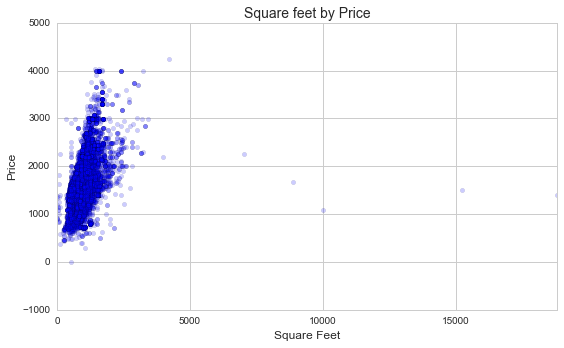

In [134]:
# generate a scatterplot for price vs square feet 
# and create lists as inputs
x = [a for a in data['square feet']]
y = list(data['price'])
# generate plot object
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)
# set plot configurations
ax.set_xlim([0, max(x)])
ax.set_xlabel('Square Feet', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Square feet by Price', fontsize=14)
# set plot layout
ax.grid(True)
fig.tight_layout()
plt.show()